## Importing Libraries

In [1]:
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

## Step 1 Data Acquisition and Visualization

In [2]:
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
# Load MNIST dataset
train_images = read_idx('train-images-idx3-ubyte.gz')
train_labels = read_idx('train-labels-idx1-ubyte.gz')
test_images = read_idx('t10k-images-idx3-ubyte.gz')
test_labels = read_idx('t10k-labels-idx1-ubyte.gz')

# Print shapes
print("Training Images Shape:", train_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Testing Images Shape:", test_images.shape)
print("Testing Labels Shape:", test_labels.shape)

Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Testing Images Shape: (10000, 28, 28)
Testing Labels Shape: (10000,)


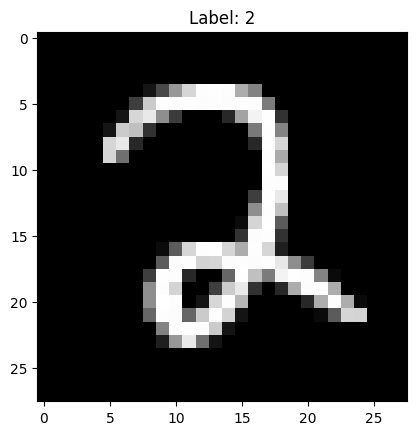

In [4]:
# Visualize a random image
index = np.random.randint(0, len(train_images))
plt.imshow(train_images[index], cmap='gray')
plt.title(f"Label: {train_labels[index]}")
plt.show()

## Step 2 Data Preprocessing

In [5]:
# Normalize pixel values
train_images_normalized = train_images / 255.0
test_images_normalized = test_images / 255.0

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

num_classes = 10
train_labels_onehot = one_hot_encode(train_labels, num_classes)
test_labels_onehot = one_hot_encode(test_labels, num_classes)

Text(0.5, 1.0, 'Original\nLabel: 1')

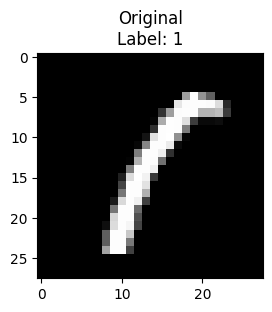

In [6]:
# Display processed data
index = np.random.randint(0, len(train_images))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(train_images[index], cmap='gray')
plt.title(f"Original\nLabel: {train_labels[index]}")

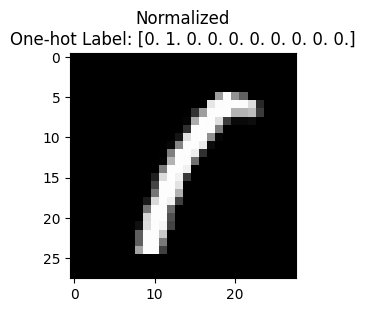

In [7]:
# Normalized Image
plt.subplot(1, 2, 2)
plt.imshow(train_images_normalized[index], cmap='gray')
plt.title(f"Normalized\nOne-hot Label: {train_labels_onehot[index]}")

plt.show()

## Step 3 Network Initialization

In [8]:
# Network architecture
input_size = 784
H1_size = 128
H2_size = 64
output_size = 10

# Seed for reproducibility
np.random.seed(695)

In [9]:
# Initialize parameters with random values
W1 = np.random.randn(input_size, H1_size) * 0.01
B1 = np.zeros((1, H1_size))

W2 = np.random.randn(H1_size, H2_size) * 0.01
B2 = np.zeros((1, H2_size))

W3 = np.random.randn(H2_size, output_size) * 0.01
B3 = np.zeros((1, output_size))

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(zi):
  output = []
  for i in range(zi.shape[0]):
    output.append(np.exp(zi[i]) / np.sum(np.exp(zi[i])))
  return np.array(output)

# Step 4: Feed Forward

In [11]:
def feed_forward(x, w, b):
  return sigmoid(np.dot(x, w) + b)

In [12]:
def forward_propagation(x, W1, B1, W2, B2, W3, B3):
  H1_output = feed_forward(batch_x, W1, B1)
  H2_output = feed_forward(H1_output, W2, B2)
  softmax_output = softmax(np.dot(H2_output, W3) + B3)
  ypred = np.eye(10)[np.argmax(softmax_output, axis = 1)]

  return H1_output, H2_output, ypred

## Step 5 Backpropagation

In [13]:
def categorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples

In [14]:
def backpropagation(batch_y, ypred, H2_output, H1_output):
  output_del = ypred - batch_y
  W3_gradient = np.dot(H2_output.T, output_del)
  B3_gradient = np.sum(output_del, axis = 0, keepdims = True)

  h2_del = np.dot(output_del, W3.T) * H2_output * (1 - H2_output)
  W2_gradient = np.dot(H1_output.T, h2_del)
  B2_gradient = np.sum(h2_del, axis = 0, keepdims = True)

  h1_del = np.dot(h2_del, W2.T) * H1_output * (1 - H1_output)
  W1_gradient = np.dot(batch_x.T, h1_del)
  B1_gradient = np.sum(h1_del, axis = 0, keepdims = True)

  return W3_gradient, B3_gradient, W2_gradient, B2_gradient, W1_gradient, B1_gradient

## Step 7 Model Training

In [15]:
batch_size = 128
epochs = 100
learning_rate = 0.01

for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(train_images_normalized) - batch_size, batch_size):
        batch_x = train_images_normalized[i:i + batch_size].reshape(batch_size, -1)
        batch_y = train_labels_onehot[i:i + batch_size]

        #H1_output = feed_forward(batch_x, W1, B1)
        #H2_output = feed_forward(H1_output, W2, B2)
        #softmax_output = softmax(np.dot(H2_output, W3) + B3)
        #ypred = np.eye(10)[np.argmax(softmax_output, axis = 1)]
        H1_output, H2_output, ypred = forward_propagation(batch_x, W1, B1, W2, B2, W3, B3)

        loss = categorical_crossentropy(batch_y, ypred)

        W3_gradient, B3_gradient, W2_gradient, B2_gradient, W1_gradient, B1_gradient = backpropagation(batch_y, ypred, H2_output, H1_output)

        #output_del = ypred - batch_y
        #W3_gradient = np.dot(H2_output.T, output_del)
        #B3_gradient = np.sum(output_del, axis = 0, keepdims = True)

        #h2_del = np.dot(output_del, W3.T) * H2_output * (1 - H2_output)
        #W2_gradient = np.dot(H1_output.T, h2_del)
        #B2_gradient = np.sum(h2_del, axis = 0, keepdims = True)

        #h1_del = np.dot(h2_del, W2.T) * H1_output * (1 - H1_output)
        #W1_gradient = np.dot(batch_x.T, h1_del)
        #B1_gradient = np.sum(h1_del, axis = 0, keepdims = True)

        W3 -= learning_rate * W3_gradient
        B3 -= learning_rate * B3_gradient

        W2 -= learning_rate * W2_gradient
        B2 -= learning_rate * B2_gradient

        W1 -= learning_rate * W1_gradient
        B1 -= learning_rate * B1_gradient

        total_loss += loss

    average_loss = total_loss / (len(train_images_normalized) // batch_size)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

Epoch 1/100, Loss: 22.7098912366913
Epoch 2/100, Loss: 21.221421265719414
Epoch 3/100, Loss: 20.694206770268252
Epoch 4/100, Loss: 20.221420367960782
Epoch 5/100, Loss: 19.804907078903565
Epoch 6/100, Loss: 17.644849789141723
Epoch 7/100, Loss: 14.658223491638546
Epoch 8/100, Loss: 12.369476049443943
Epoch 9/100, Loss: 9.774455269559317
Epoch 10/100, Loss: 7.799361245480742
Epoch 11/100, Loss: 6.680817805875316
Epoch 12/100, Loss: 6.19696128292847
Epoch 13/100, Loss: 5.764765322965462
Epoch 14/100, Loss: 5.551204245630485
Epoch 15/100, Loss: 5.284137585205103
Epoch 16/100, Loss: 5.019838454939569
Epoch 17/100, Loss: 4.8680855511745404
Epoch 18/100, Loss: 4.634690507693985
Epoch 19/100, Loss: 4.455723557357108
Epoch 20/100, Loss: 4.2357049096491535
Epoch 21/100, Loss: 4.095944636576806
Epoch 22/100, Loss: 3.961719423824149
Epoch 23/100, Loss: 3.834413036471117
Epoch 24/100, Loss: 3.584412812031474
Epoch 25/100, Loss: 3.56181131572604
Epoch 26/100, Loss: 3.432659908266444
Epoch 27/100, L

In [16]:
def predict(x):
  H1_output = feed_forward(x, W1, B1)
  H2_output = feed_forward(H1_output, W2, B2)
  softmax_output = softmax(np.dot(H2_output, W3) + B3)
  ypred = np.argmax(softmax_output, axis = 1)
  return ypred

predictions = predict(test_images_normalized.reshape(test_images_normalized.shape[0], -1))
accuracy = np.mean(predictions == test_labels)
inaccurate_preds = predictions == test_labels
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.95


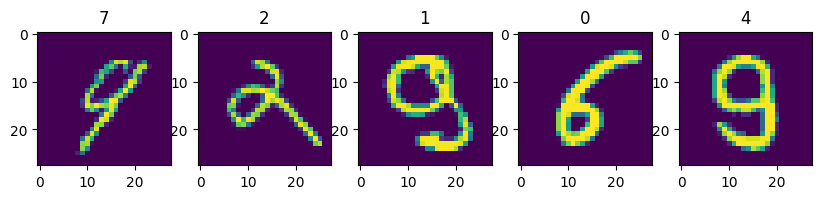

In [17]:
inaccurate_preds = []
for i in range(test_labels.shape[0]):
  if test_labels[i] != predictions[i]:
    inaccurate_preds.append(i)
inaccurate_preds = inaccurate_preds[0:5]

plt.figure(figsize = (10,5))
for i in range(len(inaccurate_preds)):
  plt.subplot(1, 5, (i+1)); plt.imshow(test_images_normalized[inaccurate_preds[i]]); plt.title(predictions[i])